In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

%load_ext autoreload
%autoreload 2


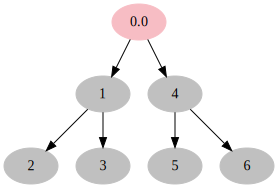

In [2]:
from distributions import Categorical
from mouselab import MouselabEnv
env = MouselabEnv(height=2, reward=Categorical([-1, 1]), cost=0.1)
env.render()

# Define features

In [3]:
from toolz.curried import *
# max_paths = len(click_features(env.init, 1)) / 3
max_paths = 2

@curry
def path_features(state, path):
    val = env.node_value_to(path[-1], state=state)
    return [val.mean, val.var, val.mean * val.var]

def click_features(state, click):
    x = np.zeros(6)
    pfs = sorted(map(path_features(state), env.all_paths(start=click)))
    while len(pfs) < max_paths:
        pfs.append([0, 0, 0])
    return np.concatenate(pfs)

# Regress to optimal policy

In [15]:
from exact import solve, hash_tree
Q, V, pi, info = solve(env)
V(env.init)

0.8999999999999999

In [5]:
from toolz import memoize
   
def regression_data():
    """Returns features and Q* for all(*) state-action pairs in an env.
    
    (*) the state space is reduced by treating symmetric states as one.
    """
#     Q, V, pi, info = solve(env)
    data = []
    @memoize(key=lambda args, kwargs: hash_tree(env, args[0]))
    def rec(s):
        for a in env.actions(s):
            if a == env.term_action: continue
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': click_features(s, a),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)

df = regression_data()

In [6]:
from sklearn.linear_model import LinearRegression
X = np.stack(df.features)
model = LinearRegression().fit(X, df.q_star)

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


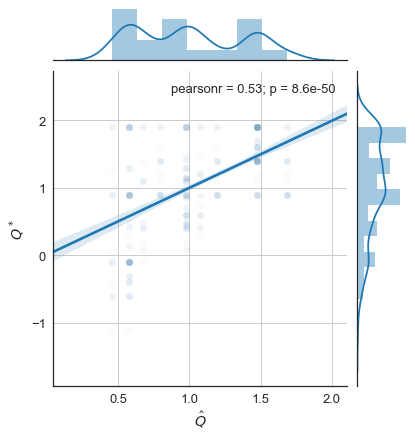

In [7]:
sns.jointplot(model.predict(X), df.q_star, kind='reg',
              joint_kws=dict(scatter_kws=dict(alpha=0.01)))
plt.grid()
plt.ylabel(r'$Q^*$')
plt.xlabel(r'$\hat{Q}$')

# Learn a max-Q policy

In [23]:
from agents import Agent
from human_model import HumanPolicy
from policies import RandomPolicy

In [16]:
agent = Agent()
agent.register(env)
agent.register(HumanPolicy(np.r_[model.intercept_, model.coef_]))
df = pd.DataFrame(agent.run_many(1000))

array([ -4.134e+12,  -5.002e-02,   4.134e+12,  -3.082e+13,   4.908e-02,   3.082e+13])

In [33]:
model.coef_

array([ -4.134e+12,  -5.002e-02,   4.134e+12,  -3.082e+13,   4.908e-02,   3.082e+13])

In [35]:
envs = [env] * 100

[autoreload of human_model failed: Traceback (most recent call last):
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/fred

In [41]:
from human_model import HumanPolicy

HumanPolicy.optimize([env] * 200, verbose=True, n_calls=50)

[ 1.323 -8.031  3.315  6.405 -1.153  9.786  1.248] -> 0.62 in 1 sec
[-5.267  7.876 -1.804  7.774 -9.534 -7.836 -6.068] -> 0.0 in 0 sec
[-1.68   4.69  -2.807  6.342 -4.976  0.431  5.518] -> 0.0 in 0 sec
[-3.831  6.929 -0.604 -6.58   7.505 -1.64   2.287] -> 0.0 in 0 sec
[ 4.271  2.983 -5.616 -8.306 -3.651  5.839  2.014] -> 0.342 in 1 sec
[ 7.592 -2.032  8.658 -5.142 -1.433  7.91   6.459] -> 0.66 in 1 sec
[-0.277 -9.494 -0.173 -0.245  9.892  0.541  8.108] -> 0.44 in 1 sec
[-0.518  2.67   9.294  1.272  3.759  0.326 -5.341] -> 0.51 in 1 sec
[-1.605  5.895  3.488 -6.109 -6.263 -8.919 -8.402] -> 0.418 in 1 sec
[-0.909 -4.937  4.865  5.226  5.081 -9.011  9.262] -> 0.661 in 1 sec
[ 9.169 -3.636  8.131 -6.113 -2.772  8.596  9.529] -> 0.67 in 1 sec
[ 2.825 -5.532  6.127  1.617 -1.061 -1.936  4.713] -> 0.65 in 1 sec
[ 10.     -4.62    9.077 -10.     -3.646  10.     10.   ] -> 0.62 in 1 sec
[  9.407  -2.544   7.607  -4.38   -1.573   8.612  10.   ] -> 0.71 in 1 sec
[ 10.     -1.687   7.103  -3.66   

In [46]:
from evaluation import get_util
from policies import FixedPlanPolicy, LiederPolicy
def data():
    agent = Agent()
    agent.register(env)
    policies = {
        'human': human,
        'random': RandomPolicy(),
        'full-observation': FixedPlanPolicy(range(1, env.term_action+1)),
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
    }
    for name, pol in policies.items():
        agent.register(pol)
        df = pd.DataFrame(agent.run_many(1000))
        df['policy'] = name
        yield df
        

df = pd.concat(data())   

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

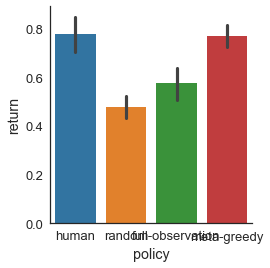

In [47]:
sns.factorplot('policy', 'return', data=df, kind='bar')

In [25]:
agent = Agent()
agent.register(env)
agent.register(RandomPolicy())
df = pd.DataFrame(agent.run_many(1000))
df['return'].mean()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

0.47539999999999999